In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType
from pyspark.sql.types import IntegerType
#from pyspark import SparkFiles
#from pyspark.sql.functions import avg, col, concat, count, desc, \
#asc, explode, lit, min, max, split, stddev, udf, isnan, when, rank, \
#log, sqrt, cbrt, exp, sum

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, \
LogisticRegressionModel, RandomForestClassifier, \
RandomForestClassificationModel, GBTClassifier, \
GBTClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, \
PCA, RegexTokenizer, Tokenizer, StandardScaler, StopWordsRemover, \
StringIndexer, VectorAssembler, MaxAbsScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import time
import tqdm
import re
import numpy as np
import scipy
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import random
%matplotlib inline
random.seed(42)

In [2]:
def create_spark_session():
    '''
    Create a spark session
    INPUT
    spark session builder
    OUTPUT
    spark object
    '''
    spark = SparkSession\
    .builder \
    .master("local") \
    .appName("sparkify") \
    .config("config option", "config value")\
    .getOrCreate()
    print('Spark parameters:')
    for parameter in spark.sparkContext.getConf().getAll():
        print(parameter)

    return spark

In [3]:
def load_models():
    lr_best_model = LogisticRegressionModel.load("logistic_stages")
    rf_best_model = RandomForestClassificationModel.load("random_forest_stages")
    gbt_best_model = GBTClassificationModel.load("gradient_boosted_tree_stages")

    return lr_best_model, rf_best_model, gbt_best_model

In [4]:
def log_loss(df):

    # extract predicted probability
    get_prob_zero = F.udf(lambda v:float(v[0]), FloatType())
    get_prob_one = F.udf(lambda v:float(v[1]), FloatType())
    df = df.withColumn("prob_zero", get_prob_zero(F.col("probability")))
    df = df.withColumn("prob_one", get_prob_one(F.col("probability")))
    #df = df.withColumn("log_zero", F.log(F.col("prob_zero")))
    #df = df.withColumn("log_one", F.log(F.col("prob_one")))
    

    #df = df.withColumn("logloss", -(F.col("label")*F.log(F.col("prob_one"))+ (1 - F.col("label"))*F.log(1-F.col("prob_one"))))
    
    #nll = -(y1*F.log(p1) + y0*F.log(p0))
    # aggregate
    return df.select("label", "probability", "prediction", "prob_zero", "prob_one")

    
    
def gen_logloss_metric(rf_yhat_test, lr_yhat_test, gbt_yhat_test):
    logloss = {}
    logloss['rf'] = log_loss(rf_yhat_test)
    logloss['lr'] = log_loss(lr_yhat_test)
    logloss['gbt'] = log_loss(gbt_yhat_test)
    logloss_df = pd.DataFrame.from_dict(logloss, orient = 'index', columns = ['logloss'])
    logloss_df.to_csv('logloss.csv', index = True)
    
    return logloss

def calculate_logloss(df):

    df['logloss'] = -(df.label*np.log10(df.prob_one) + (1 - df.label)*np.log10(df.prob_zero))
    
    return df

def get_plot_cols(df):
    idx = df.prob_zero.sort_values().index
    x = df.prob_zero.sort_values().values
    df['logloss'].index = idx
    y = df.logloss.cumsum()
    
    return x, y

In [5]:
spark = create_spark_session()

Spark parameters:
('spark.master', 'local')
('spark.app.id', 'local-1633012391527')
('spark.driver.port', '42437')
('spark.app.name', 'sparkify')
('spark.driver.host', 'fb329ea7c6af')
('spark.rdd.compress', 'True')
('spark.serializer.objectStreamReset', '100')
('config option', 'config value')
('spark.executor.id', 'driver')
('spark.submit.deployMode', 'client')
('spark.ui.showConsoleProgress', 'true')


In [6]:
rf_yhat_test = spark.read.load("rf_preds.parquet")
lr_yhat_test = spark.read.load("lr_preds.parquet")
gbt_yhat_test = spark.read.load("gbt_preds.parquet")
lr, rf, gbt = load_models()

In [7]:
rf_loss = log_loss(rf_yhat_test)
lr_loss = log_loss(lr_yhat_test)
gbt_loss = log_loss(gbt_yhat_test)

In [8]:
rf_loss.show(5)

+-----+--------------------+----------+-----------+---------+
|label|         probability|prediction|  prob_zero| prob_one|
+-----+--------------------+----------+-----------+---------+
|    0|[0.63210858585858...|       0.0| 0.63210857|0.3678914|
|    1|[0.10124999999999...|       1.0|    0.10125|  0.89875|
|    1|[0.05325311942959...|       1.0|0.053253118|0.9467469|
|    1|[0.00287141779788...|       1.0|0.002871418|0.9971286|
|    1|[0.00287141779788...|       1.0|0.002871418|0.9971286|
+-----+--------------------+----------+-----------+---------+
only showing top 5 rows



https://stackoverflow.com/questions/50061577/how-to-create-a-new-column-based-on-calculations-made-in-other-columns-in-pyspar

In [9]:
rf_pd = rf_loss.toPandas()
lr_pd = lr_loss.toPandas()
gbt_pd = gbt_loss.toPandas()

In [10]:
rf_pd = calculate_logloss(rf_pd)
lr_pd = calculate_logloss(lr_pd)
gbt_pd = calculate_logloss(gbt_pd)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10


In [11]:
lr_pd['logloss'].replace(np.inf, np.nan, inplace = True)
lr_pd.logloss.fillna(0, inplace = True)

In [12]:
rf_pd['logloss'].sum()

11.433021439705044

In [13]:
lr_pd['logloss'].sum()

74.98453191936207

In [14]:
gbt_pd['logloss'].sum()

11.77735310792923

In [15]:
rf_x, rf_y = get_plot_cols(rf_pd)
lr_x, lr_y = get_plot_cols(lr_pd) 
gbt_x, gbt_y = get_plot_cols(gbt_pd) 

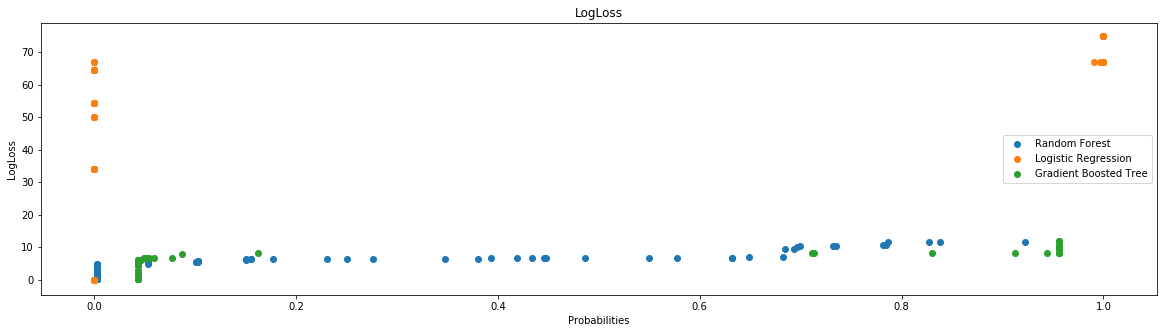

In [20]:
plt.figure(figsize = [20,5])
plt.scatter(rf_x, rf_y, label = "Random Forest")
plt.scatter(lr_x, lr_y, label ="Logistic Regression")
plt.scatter(gbt_x, gbt_y, label = "Gradient Boosted Tree")
plt.legend()
plt.title('LogLoss')
plt.ylabel('LogLoss')
plt.xlabel('Probabilities');

(5.5, 10)

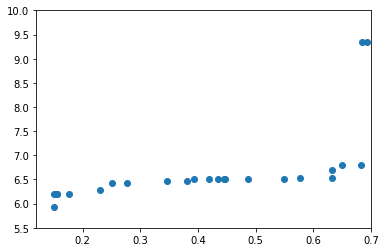

In [17]:
plt.scatter(rf_x, rf_y)
plt.xlim(0.12, 0.7)
plt.ylim(5.5,10)

In [30]:
lr.explainParams()

"aggregationDepth: suggested depth for treeAggregate (>= 2) (default: 2)\nelasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty (default: 0.0)\nfamily: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial. (default: auto)\nfeaturesCol: features column name (current: scaled)\nfitIntercept: whether to fit an intercept term (default: True)\nlabelCol: label column name (current: label)\nlowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. (undefined)\nlowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. (undefined)\nmaxIter: maximum number of iterations (>= 0) (default: 100)\npredictionCol: prediction column name (default: prediction)\nprobabilityCol: Column name for predicted class conditional probabilitie

In [12]:
lr_best_model.explainParams()

"aggregationDepth: suggested depth for treeAggregate (>= 2) (default: 2)\nelasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty (default: 0.0)\nfamily: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial. (default: auto)\nfeaturesCol: features column name (current: scaled)\nfitIntercept: whether to fit an intercept term (default: True)\nlabelCol: label column name (current: label)\nlowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. (undefined)\nlowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. (undefined)\nmaxIter: maximum number of iterations (>= 0) (default: 100)\npredictionCol: prediction column name (default: prediction)\nprobabilityCol: Column name for predicted class conditional probabilitie

In [31]:
[k for k in lr.extractParamMap(extra=None).keys()][0]

Param(parent='LogisticRegression_931519c8772f', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)')

In [32]:
type([k for k in lr.extractParamMap(extra=None).keys()][0])

pyspark.ml.param.Param

In [33]:
lr.explainParam('aggregationDepth')

'aggregationDepth: suggested depth for treeAggregate (>= 2) (default: 2)'

In [34]:
lr_params = {param[0].name: [param[1], param[0].doc] for param in lr.extractParamMap().items()}
lr_params_pd = pd.DataFrame.from_dict(lr_params, orient = 'index')
lr_params_pd.to_csv('lr_params.csv')

In [35]:
rf_params = {param[0].name: [param[1], param[0].doc] for param in rf.extractParamMap().items()}
rf_params_pd = pd.DataFrame.from_dict(rf_params, orient = 'index')
rf_params_pd.to_csv('rf_params.csv')

In [36]:
gbt_params = {param[0].name: [param[1], param[0].doc] for param in gbt.extractParamMap().items()}
gbt_params_pd = pd.DataFrame.from_dict(gbt_params, orient = 'index')
gbt_params_pd.to_csv('gbt_params.csv')

In [29]:
lr.explainParams()

"aggregationDepth: suggested depth for treeAggregate (>= 2) (default: 2)\nelasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty (default: 0.0)\nfamily: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial. (default: auto)\nfeaturesCol: features column name (current: scaled)\nfitIntercept: whether to fit an intercept term (default: True)\nlabelCol: label column name (current: label)\nlowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. (undefined)\nlowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. (undefined)\nmaxIter: maximum number of iterations (>= 0) (default: 100)\npredictionCol: prediction column name (default: prediction)\nprobabilityCol: Column name for predicted class conditional probabilitie

In [34]:
lr.params

[Param(parent='LogisticRegression_931519c8772f', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'),
 Param(parent='LogisticRegression_931519c8772f', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'),
 Param(parent='LogisticRegression_931519c8772f', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'),
 Param(parent='LogisticRegression_931519c8772f', name='featuresCol', doc='features column name'),
 Param(parent='LogisticRegression_931519c8772f', name='fitIntercept', doc='whether to fit an intercept term'),
 Param(parent='LogisticRegression_931519c8772f', name='labelCol', doc='label column name'),
 Param(parent='LogisticRegression_931519c8772f', name='lowerBoundsOnCoefficients', doc='The lower bounds on coefficients if fitting under bound constrai

In [35]:
rf.params

[Param(parent='RandomForestClassifier_1b92aabd3ec3', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'),
 Param(parent='RandomForestClassifier_1b92aabd3ec3', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'),
 Param(parent='RandomForestClassifier_1b92aabd3ec3', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'),
 Param(parent='RandomForestClassifier_1b92aabd3ec3', name='featuresCol', doc='features column name'),
 Param(parent='RandomForestClassifier_1b92aabd3ec3', name='impurity', doc='Criterion

In [36]:
rf.explainParams()

"cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. (default: False)\ncheckpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext (default: 10)\nfeatureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n]. (default: auto)\nfeaturesCol: features column name (current: scaled)\nimpurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)\nlabelCol: label column name (current: label)\nmaxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for a

In [42]:
rf.extractParamMap(extra=None)

{Param(parent='RandomForestClassifier_1b92aabd3ec3', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_1b92aabd3ec3', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_1b92aabd3ec3', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_1b92aabd3ec3', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entro

In [48]:
gbt_best_model.extractParamMap(extra=None)

{Param(parent='GBTClassifier_3fb615c02901', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='GBTClassifier_3fb615c02901', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='GBTClassifier_3fb615c02901', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'all',
 Param(parent='GBTClassifier_3fb615c02901', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'gini',
 Param(parent='GB